# architecture-22 ( Basic Classification ) v-6

## What's new:

1- Without RSI


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import talib


In [ ]:
# 1- Load and Scaling Features
# Load and preprocess
df = pd.read_csv('datasets-22/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Optional: Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# Drop rows with missing values
df.dropna(inplace=True)

# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [ ]:
# 2- Label trend reversals (example: a simplistic method)
def label_trend_reversals(prices, window=8, threshold=0.002):
    labels = []
    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]
        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            labels.append(1)  # Buy
        elif change < -threshold:
            labels.append(2)  # Sell
        else:
            labels.append(0)  # No reversal
    labels = [0] * (window // 2) + labels + [0] * (window - window // 2)
    return labels

df['Label'] = label_trend_reversals(df['CLOSE'].values)

In [22]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

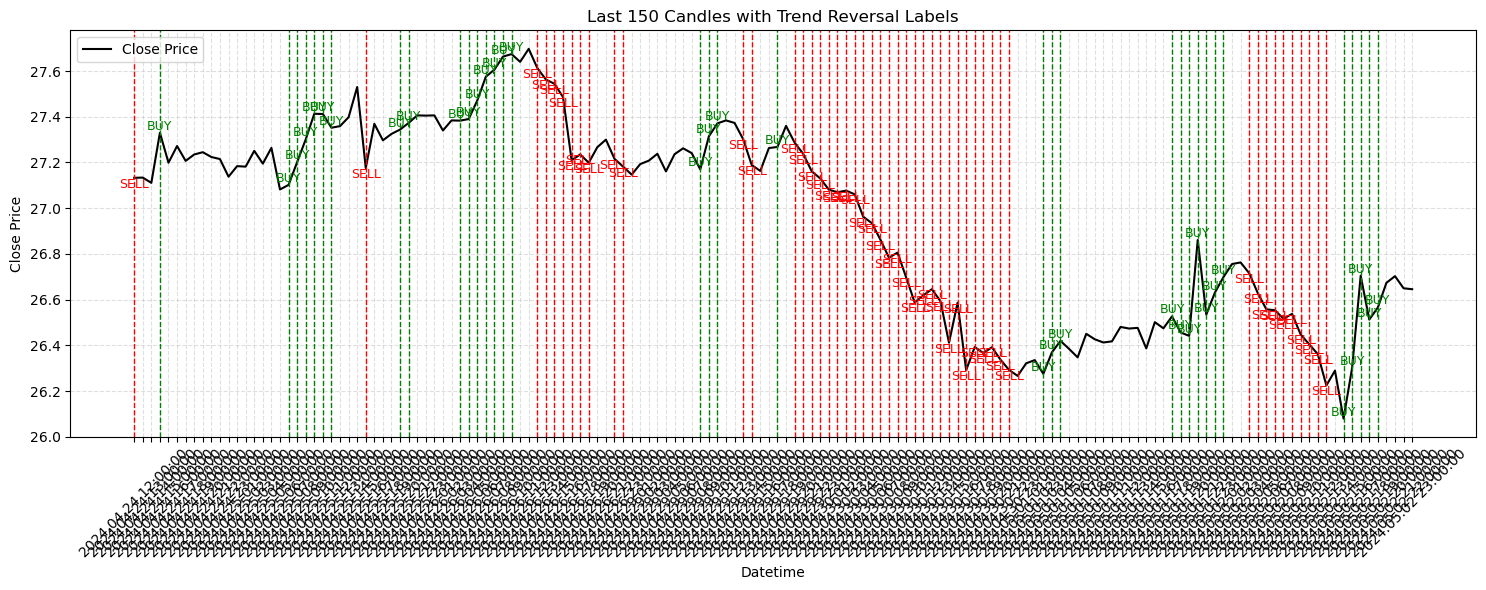

In [23]:
plot_labeled_candles(df)

In [7]:
# 3- Prepare Sequences

SEQUENCE_LENGTH = 60
FORECAST_HORIZON = 10
X, y = [], []

for i in range(SEQUENCE_LENGTH, len(scaled_data) - FORECAST_HORIZON):
    X_seq = scaled_data[i - SEQUENCE_LENGTH:i]  # (60, 5)
    y_seq = df['Label'].iloc[i:i + FORECAST_HORIZON].values  # 10 labels (0/1/2)
    X.append(X_seq)
    y.append(y_seq)

X = np.array(X)  # shape: (samples, 60, 5)
y = np.array(y)  # shape: (samples, 10)

In [8]:
# 4- Split dataset
# Reserve last sample as test input
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1:], y[-1:]

In [9]:
# 5- One-hot encode each timestep's class (3 classes → depth = 3)
# Convert labels to one-hot for each timestep
y_train_onehot = np.array([to_categorical(seq, num_classes=3) for seq in y_train])
y_test_onehot = np.array([to_categorical(seq, num_classes=3) for seq in y_test])


In [10]:
# 6- Build LSTM Classification Model
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X.shape[2])),  # (60, 5)
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(3, activation='softmax')),
    Lambda(lambda x: x[:, -FORECAST_HORIZON:, :])  # Keep only last 10 timesteps
])


I0000 00:00:1754322674.996608    3949 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2410 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [11]:
# 7- Compile model

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')
    ]
)



In [12]:
# 8- Fit model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train_onehot,
    epochs=50,  # adjust based on convergence
    batch_size=64,
    validation_split=0.1,
    shuffle=False,  # Important: keep time order!
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


I0000 00:00:1754322687.790864    4028 cuda_dnn.cc:529] Loaded cuDNN version 91001


774/774 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.4516 - loss: 1.0624 - top_2_accuracy: 0.7284 - val_accuracy: 0.4142 - val_loss: 1.0896 - val_top_2_accuracy: 0.7063
Epoch 2/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4546 - loss: 1.0639 - top_2_accuracy: 0.7272 - val_accuracy: 0.4142 - val_loss: 1.0933 - val_top_2_accuracy: 0.7063
Epoch 3/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4545 - loss: 1.0635 - top_2_accuracy: 0.7245 - val_accuracy: 0.4142 - val_loss: 1.0932 - val_top_2_accuracy: 0.7063
Epoch 4/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4543 - loss: 1.0635 - top_2_accuracy: 0.7264 - val_accuracy: 0.3355 - val_loss: 1.0962 - val_top_2_accuracy: 0.7063
Epoch 5/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4564 - loss: 1.0636 - top_2_accuracy: 0.7257 - val_accuracy: 0.2922 - val_loss: 1.0983 - val_top_2_accuracy: 0.7063
Epoch 6/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4558 - loss: 1.0644 - t

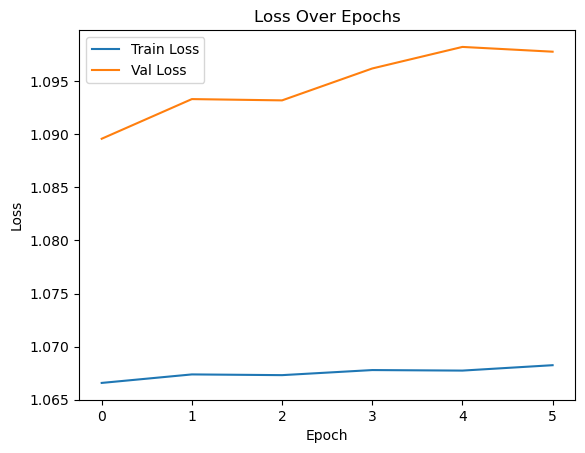

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# 9- Load the last 60 candles from a CSV file

# Load and clean
input_df = pd.read_csv('datasets-22/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv', sep='\t')
input_df.dropna(inplace=True)

input_df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Add datetime
input_df['DATETIME'] = pd.to_datetime(input_df['DATE'] + ' ' + input_df['TIME'])

# Scale
input_features = input_df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']]
input_scaled = scaler.transform(input_features)
input_sequence = np.expand_dims(input_scaled, axis=0)  # (1, 60, 5)

# Predict
pred_probs = model.predict(input_sequence)  # shape: (1, 10, 3)
pred_classes = np.argmax(pred_probs[0], axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# Timestamps for forecast
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=FORECAST_HORIZON, freq='h')

# Output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
Predicted Classes: [0 0 0 0 0 0 0 0 0 0]
             DATETIME  forecast_class label
0 2024-05-07 15:00:00               0      
1 2024-05-07 16:00:00               0      
2 2024-05-07 17:00:00               0      
3 2024-05-07 18:00:00               0      
4 2024-05-07 19:00:00               0      
5 2024-05-07 20:00:00               0      
6 2024-05-07 21:00:00               0      
7 2024-05-07 22:00:00               0      
8 2024-05-07 23:00:00               0      
9 2024-05-08 00:00:00               0      


# plot section

In [16]:
# 10- Plot section

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os
import pandas as pd

# 10-1 PARAMETERS
csv1_path = 'datasets-22/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-22/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# 10-2 LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None
# 10-3 Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=FORECAST_HORIZON, freq='h')

# 10-4 Create predicted_df with forecasted trend reversals
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})


# 10-5 Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None


predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


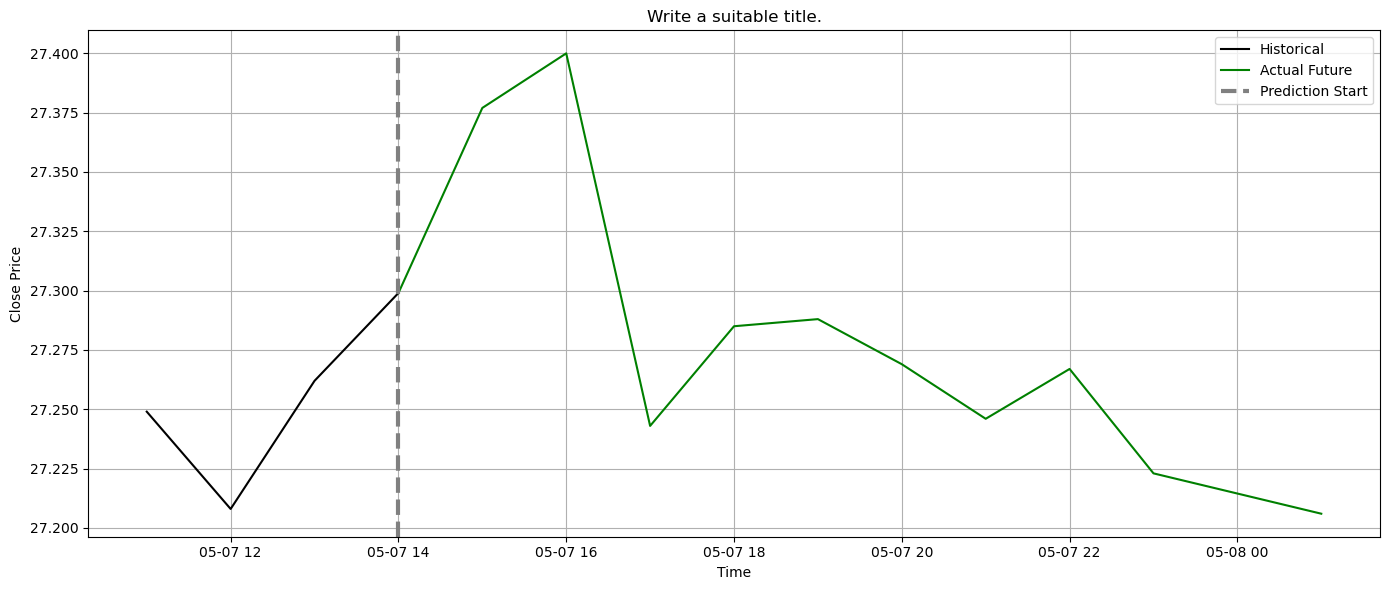

In [17]:
# 10-6 PLOT

forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [18]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy, final_test_mae = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')